### Инициализация хранилища

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# Распаковка архива с данными
!unzip -n -qq "/content/gdrive/MyDrive/Тестовое_ЦФТ/data/celeba.zip"
!ls

celeba	gdrive	output.png  sample_data  wandb


### Подключение библиотек

In [ ]:
!python -V

Python 3.8.10


In [ ]:
import os

import torch
import torch.nn as nn
import torch.optim as optim

print(torch.__version__)

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import torchvision.transforms as transforms
import torchvision

from torchvision.utils import save_image

from skimage import io

import gc
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sn
from tqdm.auto import tqdm

import pickle

# Вывод информации о платформе
import platform
print(platform.platform())

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

1.13.1+cu116
Linux-5.10.147+-x86_64-with-glibc2.29


In [ ]:
# Метод для очистки GPU
def free_gpu_cache():
    gc.collect()
    torch.cuda.empty_cache()

free_gpu_cache()



---


### Загрузка и предпросмотр данных

In [ ]:
path_to_train_csv = "./celeba/train.csv"
path_to_train_img = "./celeba/train"

In [ ]:
df = pd.read_csv(path_to_train_csv)
df.head()

,image,spoof_type,spoof_label,box
0,celeba/train/311331_2GCT8Q.jpg,REGION_MASK,1,"[223, 249, 352, 442]"
1,celeba/train/231849_7BIHZ3.jpg,PC,1,"[220, 163, 416, 455]"
2,celeba/train/494066_KP7SW6.jpg,3D_MASK,1,"[260, 217, 378, 319]"
3,celeba/train/168197_0NWR7Y.jpg,PHONE,1,"[133, 83, 360, 415]"
4,celeba/train/399267_1BS9OU.jpg,LIVE,0,"[411, 521, 1453, 2098]"


In [ ]:
df["spoof_label"].value_counts()

1    3359
0    1641
Name: spoof_label, dtype: int64

Цель работы состоит, чтобы предсказать реальное или поддельное изображение. Изображений с меткой Live в два раза меньше, чем с меткой Spoof. 
Набор данных для обучения не является сбалансированным. Имеем место применить методы аугментации для реальных изображений. 
Также в таблицах с описанием данных имеется столбец с боксом лица. Стоит сравнить модели с обрезанным изображением и без обрезки.

In [ ]:
class CelebaDataset(Dataset):
  """
  Класс для инициализации датасета
  Параметры:
  csv_file - csv файл с описанием входных данных 
            (путь, метка класса, бокс границ лица);
  root_dir - директория с изображениями;
  cropped - флаг, указывающий необходимо ли обрезать изображения по границам лица;
  transform - трансформации, которые необоходимо произвести с изображениями
  """
  def __init__(self, csv_file, root_dir, cropped = False, transform=None):
    self.annotations = pd.read_csv(csv_file)
    self.root_dir = root_dir
    self.cropped = cropped
    self.transform = transform

  def __len__(self):
    return len(self.annotations)

  def __getitem__(self, index):
    img_path = self.root_dir + '/' + self.annotations.iloc[index, 0]
    image = io.imread(img_path)

    # Если стоит флаг обрезки, то обрезать изображение по боксу лица
    if self.cropped:
      x_min, y_min, x_max, y_max = [int(i) for i 
                        in self.annotations.iloc[index, 3][1:-1].split(', ')]
      image = image[y_min:y_max, x_min:x_max]

    # Метка класса
    y_label = torch.tensor(int(self.annotations.iloc[index, 2]))

    # Если задана трансформация, то применить её
    if self.transform:
      image = self.transform(image)
    
    # Подгонка всех изображений к одному размеру
    transform = transforms.Resize(size = (200,200))
    image = transform(image)

    return (image, y_label)



---



---


## Блок аугментации данных

In [ ]:
!rm -r ./celeba/train_aug
# Создаем копию тренировочных данных, которые будем аугментировать
!cp -r ./celeba/train ./celeba/train_aug 

In [ ]:
# В качестве аугментации применим отражение изображений
df = pd.read_csv('./celeba/train.csv')

my_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(p=1.0),
    transforms.ToTensor()
    ]
)
len_df = len(df)
for i, row in df.iterrows():
  print(f'Image {i + 1} / {len_df}')
  image_name, spoof_type,	spoof_label, box_str = row

  split_path = image_name.split('/')
  # Если изображение является подделкой, то меняем только путь, 
  # иначе создаем новое изображение
  if spoof_label == 1: 
    df.iloc[i, 0] = split_path[0] + '/' + split_path[1] + '_aug/' + split_path[2]
  else:
    img = io.imread('./' + image_name)
    height, width, _ = img.shape
    
    transform_img = my_transform(img)

    # Добавляем к имени изображения постфикс '_aug'
    split_name = split_path[-1].split('.')
    new_img_path = split_path[0] + '/' + split_path[1] + '_aug/' + split_name[0] + '_aug.' + split_name[1]
    # Для оригинального изображения меняем путь 
    df.iloc[i, 0] = split_path[0] + '/' + split_path[1] + '_aug/' + split_path[2]

    # Сохраняем новое изображение
    save_image(transform_img, new_img_path)
    
    # Вычисляем новые координаты бокса
    x_min, y_min, x_max, y_max = [int(i) for i in box_str[1:-1].split(', ')]
    # Координаты по Y сохраняются, а по X вычисляются через x_new = img_x_max - x_old
    x_new_max = width - x_min
    x_new_min = width - x_max

    # Добавляем новые данные в датафрейм
    df.loc[len(df.index)] = [new_img_path, 
                            spoof_type, 
                            spoof_label, 
                            [x_new_min, y_min, x_new_max, y_max]
                            ]

# Сохраняем описание для аугментированных данных
df.to_csv('./celeba/train_aug.csv',index=False)

Image 1 / 5000
Image 2 / 5000
Image 3 / 5000
Image 4 / 5000
Image 5 / 5000
Image 6 / 5000
Image 7 / 5000
Image 8 / 5000
Image 9 / 5000
Image 10 / 5000
Image 11 / 5000
Image 12 / 5000
Image 13 / 5000
Image 14 / 5000
Image 15 / 5000
Image 16 / 5000
Image 17 / 5000
Image 18 / 5000
Image 19 / 5000
Image 20 / 5000
Image 21 / 5000
Image 22 / 5000
Image 23 / 5000
Image 24 / 5000
Image 25 / 5000
Image 26 / 5000
Image 27 / 5000
Image 28 / 5000
Image 29 / 5000
Image 30 / 5000
Image 31 / 5000
Image 32 / 5000
Image 33 / 5000
Image 34 / 5000
Image 35 / 5000
Image 36 / 5000
Image 37 / 5000
Image 38 / 5000
Image 39 / 5000
Image 40 / 5000
Image 41 / 5000
Image 42 / 5000
Image 43 / 5000
Image 44 / 5000
Image 45 / 5000
Image 46 / 5000
Image 47 / 5000
Image 48 / 5000
Image 49 / 5000
Image 50 / 5000
Image 51 / 5000
Image 52 / 5000
Image 53 / 5000
Image 54 / 5000
Image 55 / 5000
Image 56 / 5000
Image 57 / 5000
Image 58 / 5000
Image 59 / 5000
Image 60 / 5000
Image 61 / 5000
Image 62 / 5000
Image 63 / 5000
I

In [ ]:
df_aug = pd.read_csv('./celeba/train_aug.csv')
df_aug.head(15)

,image,spoof_type,spoof_label,box
0,celeba/train_aug/311331_2GCT8Q.jpg,REGION_MASK,1,"[223, 249, 352, 442]"
1,celeba/train_aug/231849_7BIHZ3.jpg,PC,1,"[220, 163, 416, 455]"
2,celeba/train_aug/494066_KP7SW6.jpg,3D_MASK,1,"[260, 217, 378, 319]"
3,celeba/train_aug/168197_0NWR7Y.jpg,PHONE,1,"[133, 83, 360, 415]"
4,celeba/train_aug/399267_1BS9OU.jpg,LIVE,0,"[411, 521, 1453, 2098]"
5,celeba/train_aug/244727_03ZG81.jpg,UPPER_BODY_MASK,1,"[159, 292, 296, 512]"
6,celeba/train_aug/120940_CDP1UQ.jpg,LIVE,0,"[198, 94, 376, 335]"
7,celeba/train_aug/018436_AN6GGX.jpg,FACE_MASK,1,"[174, 212, 411, 582]"
8,celeba/train_aug/187608_XPMP4U.jpg,LIVE,0,"[137, 143, 500, 701]"
9,celeba/train_aug/276926_0I0BAO.jpg,REGION_MASK,1,"[187, 182, 358, 431]"


In [ ]:
df_aug['spoof_label'].value_counts()

1    3359
0    3282
Name: spoof_label, dtype: int64

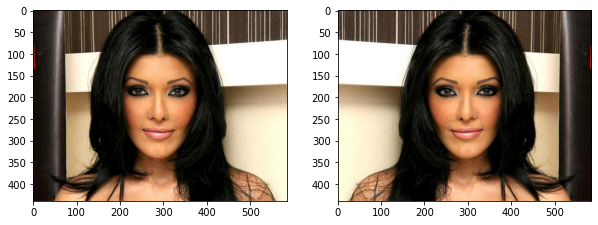

In [ ]:
img = io.imread('./celeba/train_aug/120940_CDP1UQ.jpg')
img_aug = io.imread('./celeba/train_aug/120940_CDP1UQ_aug.jpg')

plt.figure(figsize=(10, 5))

plt.subplot(121)
plt.imshow(img)

plt.subplot(122)
plt.imshow(img_aug)

In [ ]:
img_aug.shape

(439, 585, 3)



---



---




### Выбор моделей для эксперимента

In [ ]:
%%capture
!pip install wandb --upgrade

In [ ]:
import wandb

wandb.login()

True

In [ ]:
config = dict(
    epochs = 5,
    classes = 2,
    batch_size = 60,
    learning_rate=1e-3,
    dataset='celeba',
    model_name='efficientnet_aug_data'
)

In [ ]:
def makeConfusionMatrix(model, test_data_loader, img_path="output.png"):
  # Расчёт матрицы ошибок 
  confmatrix = np.zeros((2, 2))

  model.eval()
  labels_true, labels_pred = [], []
  # Работа с батчами из тестового датасета
  for i, (test_items, test_classes) in enumerate(test_data_loader):
      # Перемещение датасетов в память GPU
      test_items, test_classes = test_items.to(device), test_classes.to(device)
      # Передача картинок в модель и получение предсказаний 
      outputs = model(test_items)
      
      _, predicted = torch.max(outputs.data, 1)
      labels_pred.extend(predicted.data.cpu().numpy())
      labels_true.extend(test_classes.data.cpu().numpy())

      # Очистка памяти
      del outputs, test_items, test_classes
      free_gpu_cache()

  cm = confusion_matrix(labels_true, labels_pred, labels=[0,1])
  ax = sns.heatmap(cm, annot=True, cmap='Greens')

  ax.set_xlabel('\nPredicted labels')
  ax.set_ylabel('True labels ');

  ax.xaxis.set_ticklabels(['Live','Spoof'])
  ax.yaxis.set_ticklabels(['Live','Spoof'])

  plt.show()
  
  ax.figure.savefig(img_path)

In [ ]:
def make(config):
    dataset_train = CelebaDataset(csv_file="./celeba/train_aug.csv", 
                        root_dir='./', 
                        cropped=True,
                        transform = transforms.ToTensor()
                        )
    dataset_test = CelebaDataset(csv_file="./celeba/test.csv", 
                            root_dir='./',
                            cropped=True,
                            transform = transforms.ToTensor()
                            )

    train_loader = DataLoader(dataset = dataset_train, batch_size=config.batch_size, shuffle=True)
    test_loader = DataLoader(dataset = dataset_test, batch_size=config.batch_size, shuffle=True)

    # Make the model
    model = torchvision.models.efficientnet_b0(pretrained=True)

    # Установка исследуемого классификатора модели
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.4, inplace=True),
        nn.Linear(in_features=1280, out_features=350, bias=True),
        nn.Linear(350, 2)
    )

    model.to(device)

    # Make the loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(
        model.parameters(), lr=config.learning_rate)
    
    return model, train_loader, test_loader, criterion, optimizer

In [ ]:
def model_pipeline(hyperparameters):
  # Необходимость сохранения каждую эпоху
  save_every_epoch = False

  # Массивы с информацией о ходе обучения
  train_loss = []
  test_loss = []
  train_accuracy = []
  test_accuracy = []  

  # Инициализация начальной информации о лучшей модели
  best_accuracy = 0
  best_model = None

  # Указываем, какой блок будем логировать 
  with wandb.init(project="Test_task_bathes", 
                  name=f"efficientnet_batch_60", 
                  config=hyperparameters):
    config = wandb.config

    model, train_loader, test_loader, criterion, optimizer = make(config)
    # print(model)
    
    example_ct = 0 # Счетчик элементов 

    # Обучение модели за число эпох: config.epochs 
    for epoch in tqdm(range(config.epochs)):
      # Инициализация переменных для сохранения данных по эпохе
      train_correct = 0
      train_total = 0
      
      epoch_train_loss = []
      epoch_test_loss = []
      epoch_train_accuracy = []
      epoch_test_accuracy = []
      
      # Очистка памяти GPU 
      free_gpu_cache()

      # Перевод модели в режим обучения
      model.train()
      
      # Работа с батчами из тренировочного датасета
      for i, (images, labels) in enumerate(train_loader):
          
          images, labels = images.to(device), labels.to(device)
          
          example_ct +=  len(images)
          
          # Очистка градиентов после прошедших вычислений
          optimizer.zero_grad()
          # Передача картинок в модель и получение предсказаний 
          outputs = model(images)
          # Вычисление функции потерь
          loss = criterion(outputs, labels)
          # Вычисление градиентов
          loss.backward()
          # Оптимизация параметров
          optimizer.step()
          
          # Расчёт качества работы модели
          train_total += 1
          correct = torch.argmax(outputs, dim=1).eq(labels)
          train_accuracy_item = torch.mean(correct.float())
          
          # Запись результатов
          epoch_train_loss.append(loss.item())
          epoch_train_accuracy.append(float(train_accuracy_item.item()))

          # Удаление из памяти неиспользуемых объектов
          del outputs, images, labels
          del correct, train_accuracy_item
          free_gpu_cache()
        
        
      # Перевод модели в режим теста
      model.eval()

      # Работа с батчами из тестового датасета
      for i, (test_images, test_labels) in enumerate(test_loader):
        # Перемещение датасетов в память GPU
        test_images, test_labels = test_images.to(device), test_labels.to(device)

        # Передача картинок в модель и получение предсказаний 
        outputs = model(test_images)

        # Вычисление значения функции потерь
        loss = criterion(outputs, test_labels)

        # Расчёт качества работы модели
        correct = torch.argmax(outputs, dim=1).eq(test_labels)
        test_accuracy_item = torch.mean(correct.float())

        # Запись результатов
        epoch_test_loss.append(float(loss.item()))
        epoch_test_accuracy.append(float(test_accuracy_item.item()))

        # Удаление из памяти неиспользуемых объектов
        del outputs, test_images, test_labels
        del correct, test_accuracy_item
        free_gpu_cache()

       

      # Расчёт средних величин результатов
      epoch_train_loss = np.mean(epoch_train_loss)
      epoch_test_loss = np.mean(epoch_test_loss)
      epoch_train_accuracy = np.mean(epoch_train_accuracy)
      epoch_test_accuracy = np.mean(epoch_test_accuracy)

      wandb.log({"Loss_train": epoch_train_loss, 
                  "Acc_train": epoch_train_accuracy,
                  "Loss_test": epoch_test_loss, 
                  "Acc_test": epoch_test_accuracy,
                  }, step=epoch)
      

      # Добавление в общий список результатов за эпоху
      train_loss.append(epoch_train_loss)
      test_loss.append(epoch_test_loss)
      train_accuracy.append(epoch_train_accuracy)
      test_accuracy.append(epoch_test_accuracy)

      # Информация об эпохе
      print('===Epoch %d/%d, Loss: %.4f, Accuracy: %.3f, Test Accuracy: %.3f' 
                %(epoch+1, config.epochs, epoch_train_loss,  
                  epoch_train_accuracy, epoch_test_accuracy))
      
      # Сохранение в память лучшей модели
      if epoch_test_accuracy > best_accuracy:
        best_accuracy = epoch_test_accuracy
        best_model = pickle.loads(pickle.dumps(model))
  
    makeConfusionMatrix(best_model, test_loader)
    image = wandb.Image('output.png', caption="Top: Output, Bottom: Input")

    wandb.log({"Confusion Matrix": image})
   
  return best_model

In [ ]:
model = model_pipeline(config)

In [ ]:
model_load = torch.jit.load('gdrive/MyDrive/' + config['model_name'] + 'JIT.pth')
model_load.eval()